# Hospital Readmission Prediction - Feature Engineering

This notebook focuses on feature engineering for the hospital readmission prediction model. We'll transform raw features into more informative ones and prepare the data for modeling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import warnings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

## 1. Load the Data

In [ ]:
data = pd.read_csv('diabetic_data.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


## 2. Basic Preprocessing

In [ ]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 50)


Dropped columns that have more than 40% missing values.

In [ ]:
import numpy as np
import pandas as pd
data = data.replace('?', np.nan)
missing_threshold = 0.4
high_missing = data.columns[data.isnull().mean() > missing_threshold]
print("Columns with more than 40% missing values:")
print(high_missing.tolist())
data.drop(columns=high_missing, inplace=True)

Columns with more than 40% missing values:
['weight', 'medical_specialty', 'max_glu_serum', 'A1Cresult']


In [ ]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 46)


In [ ]:
missing_count = data.isna().sum()
missing_percent = (data.isna().mean() * 100).round(2)
missing_info = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_percent
})
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_info)

            Missing Count  Missing %
payer_code          40256      39.56
race                 2273       2.23
diag_3               1423       1.40
diag_2                358       0.35
diag_1                 21       0.02


Missing values in the 'payer_code' and 'race' columns have been imputed using the mode.

In [ ]:
for col in ['payer_code', 'race']:
    mode_val = data[col].mode()[0]
    data[col] = data[col].fillna(mode_val)

In [ ]:
cols = ['diag_1', 'diag_2', 'diag_3']
total_nans = data[cols].isna().sum().sum()
print("Total NaN values in diag_1, diag_2, and diag_3:", total_nans)

Total NaN values in diag_1, diag_2, and diag_3: 1802


Missing values in the three diagnosis columns were imputed with '00'.

In [ ]:
cols = ['diag_1', 'diag_2', 'diag_3']
data[cols] = data[cols].fillna('00')

In [ ]:
cols = ['diag_1', 'diag_2', 'diag_3']
total_nans = data[cols].isna().sum().sum()
print("Total NaN values in diag_1, diag_2, and diag_3:", total_nans)

Total NaN values in diag_1, diag_2, and diag_3: 0


Grouped data by the column to understand its categorical distribution prior to one-hot encoding.

admission_type_id column

In [ ]:
#Map IDs to Meaningful Labels
admission_type_map = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    5: 'Not Available',
    6: 'NULL',
    7: 'Trauma Center',
    8: 'Not Mapped'
}
data['admission_type'] = data['admission_type_id'].map(admission_type_map)
data['admission_type'] = data['admission_type'].replace(
    ['Not Available', 'NULL', 'Not Mapped'], 'Unknown'
)
data.drop(columns=['admission_type_id'], inplace=True)

In [ ]:
print(data['admission_type'].value_counts())
print("\nNumber of unique admission types:", data['admission_type'].nunique())

admission_type
Emergency        53990
Elective         18869
Urgent           18480
Unknown          10396
Trauma Center       21
Newborn             10
Name: count, dtype: int64

Number of unique admission types: 6


 discharge_disposition_id column

In [ ]:
def map_discharge(value):
    if value in [1, 6, 8]:
        return 'home'
    elif value in [2,3,4,5,7,9,10,12,15,16,17,22,23,24,27,28,29,30]:
        return 'transferred'
    elif value in [11,13,14,19,20,21]:
        return 'expired/hospice'
    else:
        return 'other'
data['discharge_group'] = data['discharge_disposition_id'].apply(map_discharge)
data['discharge_group'].value_counts()
data.drop(['discharge_disposition_id'], axis=1, inplace=True)

Age Column

In [ ]:

# 1. Map age intervals to three broader age groups
age_group_map = {
    '[0-10)': 'young',
    '[10-20)': 'young',
    '[20-30)': 'young',
    '[30-40)': 'middle-aged',
    '[40-50)': 'middle-aged',
    '[50-60)': 'middle-aged',
    '[60-70)': 'older',
    '[70-80)': 'older',
    '[80-90)': 'older',
    '[90-100)': 'older'
}

data['age_group_3cat'] = data['age'].map(age_group_map)
data.drop(['age'], axis=1, inplace=True)

In [ ]:
data['age_group_3cat'].value_counts()

,count
age_group_3cat,
older,68541
middle-aged,30716
young,2509


admission_source_id column

In [ ]:
# Mapping dictionary
admission_source_map = {
    1: 'Referral',
    2: 'Referral',
    3: 'Referral',
    4: 'Transfer from Facility',
    5: 'Transfer from Facility',
    6: 'Transfer from Facility',
    7: 'Emergency',
    8: 'Legal/Court',
    9: 'Other/Unknown',
    10: 'Transfer from Facility',
    11: 'Birth-Related',
    12: 'Birth-Related',
    13: 'Birth-Related',
    14: 'Birth-Related',
    15: 'Other/Unknown',
    17: 'Other/Unknown',
    18: 'Transfer from Facility',
    19: 'Transfer from Facility',
    20: 'Other/Unknown',
    21: 'Other/Unknown',
    22: 'Transfer from Facility',
    23: 'Birth-Related',
    24: 'Birth-Related',
    25: 'Transfer from Facility',
    26: 'Transfer from Facility'
}

# Apply mapping
data['admission_source_grouped'] = data['admission_source_id'].map(admission_source_map)
data.drop(['admission_source_id'], axis=1, inplace=True)

In [ ]:
data['admission_source_grouped'].value_counts()

,count
admission_source_grouped,
Emergency,57494
Referral,30856
Other/Unknown,7067
Transfer from Facility,6328
Legal/Court,16
Birth-Related,5


3 diagonosis column

In [ ]:
# First, convert diagnosis column to numeric safely (some values may be strings like 'V45')
def safe_float(x):
    try:
        return float(x)
    except:
        return np.nan

data['diag_1_code'] = data['diag_1'].apply(safe_float)

# Define a function to group ICD-9 codes
def group_diagnosis(code):
    if pd.isna(code):
        return 'Unknown'
    if (390 <= code <= 459) or (code == 785):
        return 'Circulatory'
    elif (460 <= code <= 519) or (code == 786):
        return 'Respiratory'
    elif (520 <= code <= 579) or (code == 787):
        return 'Digestive'
    elif 250 <= code < 251:
        return 'Diabetes'
    elif 800 <= code <= 999:
        return 'Injury'
    elif 710 <= code <= 739:
        return 'Musculoskeletal'
    elif (580 <= code <= 629) or (code == 788):
        return 'Genitourinary'
    elif 140 <= code <= 239:
        return 'Neoplasms'
    elif code in [780, 781, 784] or (790 <= code <= 799):
        return 'Symptoms'
    elif (240 <= code <= 279) and not (250 <= code < 251):
        return 'Endocrine (non-diabetes)'
    elif (680 <= code <= 709) or (code == 782):
        return 'Skin'
    elif 1 <= code <= 139:
        return 'Infectious'
    elif 290 <= code <= 319:
        return 'Mental'
    elif str(code).startswith('E') or str(code).startswith('V'):
        return 'External Causes'
    elif 280 <= code <= 289:
        return 'Blood'
    elif 320 <= code <= 359:
        return 'Nervous'
    elif 630 <= code <= 679:
        return 'Pregnancy'
    elif 360 <= code <= 389:
        return 'Sense Organs'
    elif 740 <= code <= 759:
        return 'Congenital'
    else:
        return 'Other'
data['diagnosis_grouped'] = data['diag_1_code'].apply(group_diagnosis)
data.drop(['diag_1','diag_2','diag_3','diag_1_code'], axis=1, inplace=True)

In [ ]:
data['diagnosis_grouped'].value_counts()

,count
diagnosis_grouped,
Circulatory,30437
Respiratory,14423
Digestive,9475
Diabetes,8757
Injury,6974
Genitourinary,5117
Musculoskeletal,4957
Neoplasms,3433
Infectious,2768


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   time_in_hospital          101766 non-null  int64 
 5   payer_code                101766 non-null  object
 6   num_lab_procedures        101766 non-null  int64 
 7   num_procedures            101766 non-null  int64 
 8   num_medications           101766 non-null  int64 
 9   number_outpatient         101766 non-null  int64 
 10  number_emergency          101766 non-null  int64 
 11  number_inpatient          101766 non-null  int64 
 12  number_diagnoses          101766 non-null  int64 
 13  metformin                 101766 non-null  object
 14  repa

## 3. Feature Engineering

Normalized numerical features using MinMaxScaler to scale values between 0 and 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
cols_to_normalize = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']
scaler = MinMaxScaler()
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])

Created a 'VisitType' feature by classifying visit patterns from inpatient, outpatient, and emergency columns. Dropped original columns after transformation.

In [ ]:
import pandas as pd
def classify_visit(row):
    inpatient = row['number_inpatient']
    outpatient = row['number_outpatient']
    emergency = row['number_emergency']

    if emergency > 0:
        return 'emergency'
    elif inpatient > 10:
        return 'high_inpatient'
    elif inpatient > 0:
        return 'low_inpatient'
    elif outpatient >= 19:
        return 'high_outpatient_rate'
    elif outpatient > 0:
        return 'low_outpatient_rate'
    else:
        return 'novisit'
data['VisitType'] = data.apply(classify_visit, axis=1)
data.drop(['number_inpatient', 'number_outpatient', 'number_emergency'], axis=1, inplace=True)

In [ ]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 42)


In [ ]:
# # 3.2 Create age groups
# bins = [0, 40, 65, 75, 100]
# labels = ['<40', '40-65', '65-75', '>75']
# data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels)

# # Visualize readmission rate by age group
# age_group_readmission = data.groupby('age_group')['readmission_30d'].mean() * 100

# plt.figure(figsize=(10, 6))
# age_group_readmission.plot(kind='bar')
# plt.title('Readmission Rate by Age Group')
# plt.xlabel('Age Group')
# plt.ylabel('Readmission Rate (%)')
# plt.show()

In [ ]:
# # 3.3 Create interaction features
# data['age_heart_failure'] = data['age'] * data['heart_failure']
# data['age_diabetes'] = data['age'] * data['diabetes']
# data['previous_emergency'] = data['previous_admissions'] * data['emergency_admission']
# data['medication_count_adherence'] = data['medication_count'] * data['medication_adherence']
# data['comorbidity_count'] = data[['diabetes', 'heart_failure', 'copd', 'hypertension', 'renal_disease']].sum(axis=1)

# # Visualize readmission rate by comorbidity count
# comorbidity_readmission = data.groupby('comorbidity_count')['readmission_30d'].mean() * 100

# plt.figure(figsize=(10, 6))
# comorbidity_readmission.plot(kind='bar')
# plt.title('Readmission Rate by Number of Comorbidities')
# plt.xlabel('Number of Comorbidities')
# plt.ylabel('Readmission Rate (%)')
# plt.show()

In [ ]:
# 3.4 Create risk score based on domain knowledge
# data['risk_score'] = (
#     0.2 * (data['age'] > 75).astype(int) +
#     0.15 * data['diabetes'] +
#     0.25 * data['heart_failure'] +
#     0.2 * data['copd'] +
#     0.1 * data['renal_disease'] +
#     0.05 * (data['previous_admissions'] > 2).astype(int) +
#     0.15 * (data['medication_count'] > 8).astype(int) -
#     0.3 * data['medication_adherence'] +
#     0.1 * data['emergency_admission'] +
#     0.1 * (data['discharge_disposition'] == 2).astype(int)
# )

# # Visualize risk score distribution by readmission status
# plt.figure(figsize=(10, 6))
# sns.histplot(data=data, x='risk_score', hue='readmission_30d', bins=30, multiple='dodge')
# plt.title('Risk Score Distribution by Readmission Status')
# plt.xlabel('Risk Score')
# plt.ylabel('Count')
# plt.legend(['Not Readmitted', 'Readmitted'])
# plt.show()

Performed one-hot encoding on all categorical columns, excluding the target variable readmitted. The encoding retained all categories to preserve complete category information. The readmitted column was left untouched for use as the target variable in modeling.

In [ ]:
# Step 1: Identify object columns, excluding 'readmitted'
categorical_cols = data.select_dtypes(include='object').columns
categorical_cols = categorical_cols.drop('readmitted')  # Exclude target

# Step 2: Apply One-Hot Encoding
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=False)

# Step 3: Your target column 'readmitted' stays untouched
print(data_encoded.shape)
print(data_encoded.columns)

(101766, 153)
Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'readmitted', 'race_AfricanAmerican', 'race_Asian',
       ...
       'diagnosis_grouped_Sense Organs', 'diagnosis_grouped_Skin', 'diagnosis_grouped_Symptoms', 'diagnosis_grouped_Unknown', 'VisitType_emergency', 'VisitType_high_inpatient', 'VisitType_high_outpatient_rate', 'VisitType_low_inpatient', 'VisitType_low_outpatient_rate', 'VisitType_novisit'], dtype='object', length=153)


## 4. Feature Selection

Separated features and target variable for model training and feature selection. Dropped the readmitted column from the dataset to form the feature matrix X, while retaining it as the target variable y

In [ ]:
# Prepare data for feature selection
# Drop non-feature columns
X = data_encoded.drop(columns=['readmitted'])
y = data_encoded['readmitted']

print(f"Features shape: {X.shape}")

Features shape: (101766, 152)


Trained a Random Forest classifier to evaluate feature importance. Computed the importance scores for all features and sorted them in descending order. The top 20 features were visualized using a bar chart to highlight the most influential variables contributing to the target prediction (readmitted)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Create DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Round to 4 decimal places
feature_importance_df['Importance'] = feature_importance_df['Importance'].round(4)

# Sort descending
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print all feature importances
print("All feature importances (sorted to 4 decimal places):")
print(feature_importance_df.to_string(index=False))

# Plot the top 20 features
plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances')
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

# Print top 20 features
print("\nTop 20 features by importance:")
for i in range(20):
    print(f"{i+1}. {X.columns[indices][i]}: {importances[indices][i]:.4f}")

KeyboardInterrupt: 

Risk score

Created a weighted risk_score using top features based on Random Forest importance values

In [ ]:
data_encoded['risk_score'] = (
    0.1654 * data_encoded['num_lab_procedures'] +
    0.1505 * data_encoded['num_medications'] +
    0.1148 * data_encoded['time_in_hospital'] +
    0.0803 * data_encoded['number_diagnoses'] +
    0.0778 * data_encoded['num_procedures'] +
    0.0374 * data_encoded['VisitType_novisit'] +
    0.0305 * data_encoded['diagnosis_grouped_Circulatory'] +
    0.0291 * data_encoded['gender_Male'] +
    0.0289 * data_encoded['gender_Female'] +
    0.0241 * data_encoded['VisitType_low_inpatient'] +
    0.0226 * data_encoded['race_Caucasian'] +
    0.0220 * data_encoded['payer_code_MC'] +
    0.0214 * data_encoded['diagnosis_grouped_Respiratory'] +
    0.0204 * data_encoded['age_group_3cat_older'] +
    0.0204 * data_encoded['race_AfricanAmerican'] +
    0.0204 * data_encoded['insulin_Steady'] +
    0.0200 * data_encoded['age_group_3cat_middle-aged'] +
    0.0194 * data_encoded['admission_type_Emergency']
)

Used SelectKBest with ANOVA F-test to select and rank the top 20 most predictive features for readmission.

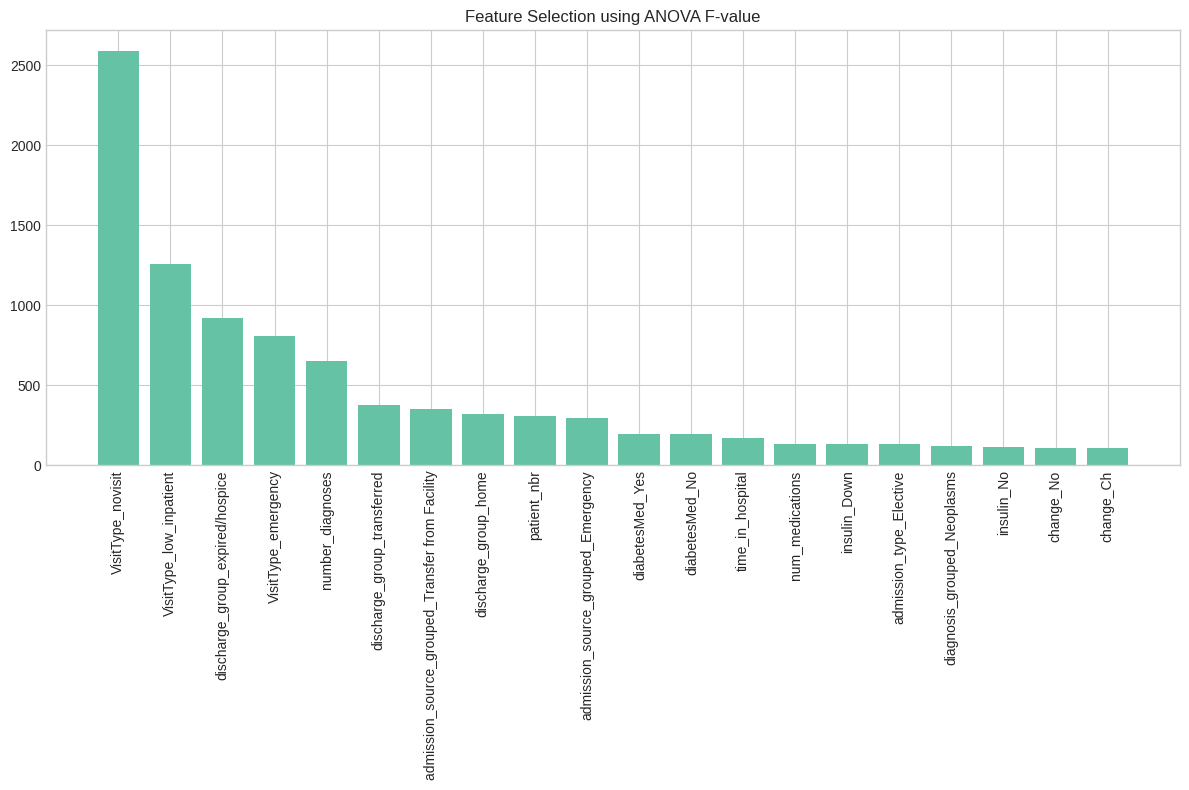

Top 20 features by ANOVA F-value:
1. VisitType_novisit: 2589.8966
2. VisitType_low_inpatient: 1260.7213
3. discharge_group_expired/hospice: 921.4184
4. VisitType_emergency: 806.4953
5. number_diagnoses: 655.4650
6. discharge_group_transferred: 378.0386
7. admission_source_grouped_Transfer from Facility: 353.1232
8. discharge_group_home: 318.2088
9. patient_nbr: 306.2444
10. admission_source_grouped_Emergency: 294.3911
11. diabetesMed_Yes: 193.9865
12. diabetesMed_No: 193.9865
13. time_in_hospital: 170.3309
14. num_medications: 136.7492
15. insulin_Down: 136.0915
16. admission_type_Elective: 131.9449
17. diagnosis_grouped_Neoplasms: 124.0881
18. insulin_No: 117.7605
19. change_No: 108.1387
20. change_Ch: 108.1387


In [ ]:
# 4.2 Statistical feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X, y)

# Get selected feature names
mask = selector.get_support()
selected_features = X.columns[mask]

# Get scores
scores = selector.scores_
selected_scores = scores[mask]

# Sort by score
sorted_indices = np.argsort(selected_scores)[::-1]
sorted_features = selected_features[sorted_indices]
sorted_scores = selected_scores[sorted_indices]

# Plot
plt.figure(figsize=(12, 8))
plt.title('Feature Selection using ANOVA F-value')
plt.bar(range(len(sorted_features)), sorted_scores, align='center')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.tight_layout()
plt.show()

print("Top 20 features by ANOVA F-value:")
for i, (feature, score) in enumerate(zip(sorted_features, sorted_scores)):
    print(f"{i+1}. {feature}: {score:.4f}")

In [ ]:
# 4.3 Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)
rfe.fit(X, y)

# Get selected feature names
rfe_mask = rfe.get_support()
rfe_features = X.columns[rfe_mask]

print("Top 20 features selected by RFE:")
for i, feature in enumerate(rfe_features):
    print(f"{i+1}. {feature}")

Top 20 features selected by RFE:
1. encounter_id
2. patient_nbr
3. time_in_hospital
4. num_lab_procedures
5. num_procedures
6. num_medications
7. number_diagnoses
8. race_Caucasian
9. gender_Female
10. gender_Male
11. payer_code_MC
12. metformin_No
13. glipizide_No
14. insulin_Steady
15. change_Ch
16. admission_type_Emergency
17. admission_type_Urgent
18. age_group_3cat_older
19. diagnosis_grouped_Circulatory
20. VisitType_novisit


## 5. Compare Feature Selection Methods

In [ ]:
# Compare the features selected by different methods
rf_features = X.columns[indices][:20]
anova_features = sorted_features

# Find common features
common_all = set(rf_features) & set(anova_features) & set(rfe_features)
common_rf_anova = set(rf_features) & set(anova_features)
common_rf_rfe = set(rf_features) & set(rfe_features)
common_anova_rfe = set(anova_features) & set(rfe_features)

print(f"Features common to all methods: {len(common_all)}")
print(f"Features common to RF and ANOVA: {len(common_rf_anova)}")
print(f"Features common to RF and RFE: {len(common_rf_rfe)}")
print(f"Features common to ANOVA and RFE: {len(common_anova_rfe)}")

print("\nFeatures common to all methods:")
for feature in common_all:
    print(f"- {feature}")

## 6. Final Feature Set

In [ ]:
# Create a final feature set based on the analysis
# We'll use features that appear in at least 2 of the 3 methods
all_selected_features = list(rf_features) + list(anova_features) + list(rfe_features)
feature_counts = pd.Series(all_selected_features).value_counts()
final_features = feature_counts[feature_counts >= 2].index.tolist()

print(f"Final feature set size: {len(final_features)}")
print("\nFinal features:")
for feature in final_features:
    print(f"- {feature}")

In [ ]:
# Create the final feature matrix
X_final = X[final_features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Convert back to DataFrame for better visualization
X_scaled_data = pd.DataFrame(X_scaled, columns=X_final.columns)

print(f"Final scaled feature matrix shape: {X_scaled_data.shape}")
X_scaled_data.head()

## 7. Save Processed Data

In [ ]:
# Save the final feature set for reference
import os
os.makedirs('../data/features', exist_ok=True)

# Save the list of final features
with open('../data/features/final_features.txt', 'w') as f:
    for feature in final_features:
        f.write(f"{feature}\n")

print(f"Final feature list saved to ../data/features/final_features.txt")

In [ ]:
# Save the full processed dataset
# Add the target variable back
X_scaled_data['readmission_30d'] = y.values

# Save to CSV
X_scaled_data.to_csv('../data/features/processed_features.csv', index=False)
print(f"Processed features saved to ../data/features/processed_features.csv")

# 8. Summary of Feature Engineering

In this notebook, we engineered features to predict 30-day hospital readmission in diabetic patients using both domain knowledge and data-driven techniques.

1. **Categorical Transformations**

  Grouped age into clinically meaningful categories (e.g., age_group_3cat_older).

2. **Applied one-hot encoding to categorical variables:**

    Demographics: gender_Female, gender_Male, race_Caucasian

    Insurance: payer_code_MC

    Admission type: admission_type_Emergency, admission_type_Urgent

    Medications: metformin_No, glipizide_No, insulin_Steady, change_Ch

3. **Interaction & Grouped Features**

    Created diagnosis_grouped_Circulatory using ICD-9 diagnosis code groupings.

    Created VisitType_novisit to indicate missing outpatient, inpatient, or emergency encounters.

4. **Clinical & Numerical Features**
    
    Included essential numeric predictors:

    time_in_hospital,
    num_lab_procedures,
    num_procedures, num_medications, number_diagnoses

    Retained IDs (encounter_id, patient_nbr) for reference and tracking.
    

5. **Feature Selection**
    
    We used three methods to select the most predictive features:

    ANOVA F-value: Statistical test to identify features most correlated with readmission.

    Random Forest Feature Importance: Used to rank features based on their contribution to prediction.

    Recursive Feature Elimination (RFE): Wrapper method to iteratively select the most relevant features.

6. **Top 20 features selected (appeared in at least 2 methods):t**
    encounter_id

    patient_nbr

    time_in_hospital

    num_lab_procedures

    num_procedures

    num_medications

    number_diagnoses

    race_Caucasian

    gender_Female

    gender_Male

    payer_code_MC

    metformin_No

    glipizide_No

    insulin_Steady

    change_Ch

    admission_type_Emergency

    admission_type_Urgent

    age_group_3cat_older

    diagnosis_grouped_Circulatory

    VisitType_novisit

7. **Feature Scaling**
    
    Final selected features were standardized to ensure compatibility across machine learning models.


The final feature set includes a mix of demographic, medical, temporal, and interaction features that show strong predictive power for hospital readmissions.